In [1]:
import tensorflow
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,Dropout,Flatten,Input,Reshape
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from keras.regularizers import l2
from sklearn.model_selection import KFold

In [2]:
# Đọc file CSV
df = pd.read_csv('labeled_images.csv')

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)


# In ra một số thông tin về dữ liệu đã chia
print("Số lượng mẫu trong tập huấn luyện:", len(train_df))
print("Số lượng mẫu trong tập kiểm tra:", len(test_df))


Số lượng mẫu trong tập huấn luyện: 1536
Số lượng mẫu trong tập kiểm tra: 384


In [3]:
def resize_image(image, target_size):
    return cv2.resize(image, target_size)

def convert_to_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

def adjust_brightness(image):
    if len(image.shape) == 2:  # Nếu ảnh đơn kênh (grayscale)
        return cv2.equalizeHist(image)

def remove_noise(image, ksize=5):
    return cv2.GaussianBlur(image, (ksize, ksize), 0)

def normalize_image(image):
    return image / 255.0

def handle_missing_values(image):
    if np.any(np.isnan(image)):
        image = np.nan_to_num(image)
    return image

def sharpen_image(image, sigma=1.0, strength=1.5):
    blurred = cv2.GaussianBlur(image, (0, 0), sigma)
    sharpened_image = cv2.addWeighted(image, 1.0 + strength, blurred, -strength, 0)
    return sharpened_image




In [4]:
def preprocess_image(image, target_size=(200, 200)):
       
    # Resize image
    image = resize_image(image, target_size)
    
    # Convert to grayscale
    image = convert_to_grayscale(image)
    
    # Adjust brightness
    image = adjust_brightness(image)
    
    # Remove noise
    image = remove_noise(image)
    
    # Handle missing values
    image = handle_missing_values(image)
    
    # Sharpen image
    image = sharpen_image(image)
    
    # Normalize image
    image = normalize_image(image)
    
    # Thêm kênh cho ảnh xám
    image = np.expand_dims(image, axis=-1)
    
    return image



In [5]:
# Tách dữ liệu đầu vào và nhãn từ DataFrame
def create_dataset(df):
    # Khởi tạo danh sách dữ liệu đầu vào (X) và nhãn (y)
    X = []
    y = []

    # Duyệt qua từng hàng trong DataFrame
    for _, row in df.iterrows():
        image_path = "data/Final_data/" + row['Filename']  # Thêm đường dẫn đến thư mục chứa ảnh
        label = row['Label']  # Sử dụng cột thứ hai làm nhãn
        

        # Đọc ảnh từ đường dẫn
        image = cv2.imread(image_path)
        
        # Kiểm tra xem việc đọc ảnh có thành công không
        if image is None:
            print(f"WARNING: Failed to read image from {image_path}. Skipping...")
            continue

        # Tiền xử lý ảnh
        image = preprocess_image(image)

        # Thêm ảnh vào danh sách dữ liệu đầu vào
        X.append(image)
        # Thêm nhãn vào danh sách nhãn
        y.append(label)

    # Chuyển đổi danh sách thành numpy arrays
    X = np.array(X)
    y = np.array(y)

    return X, y




In [6]:
# Đường dẫn tới thư mục chứa ảnh gốc
final_folder_path = 'data/Final_data'

# Tạo dữ liệu đầu vào và nhãn cho tập huấn luyện và tập kiểm tra
X_train, y_train = create_dataset(train_df)
X_test, y_test = create_dataset(test_df)

# Kiểm tra kích thước của dữ liệu đầu vào và nhãn
print("Kích thước của tập huấn luyện - X:", X_train.shape, "y:", y_train.shape)
print("Kích thước của tập kiểm tra - X:", X_test.shape, "y:", y_test.shape)

Kích thước của tập huấn luyện - X: (1536, 200, 200, 1) y: (1536,)
Kích thước của tập kiểm tra - X: (384, 200, 200, 1) y: (384,)


In [7]:
y_train = np.array(y_train)
y_test = np.array(y_test)
encoder = OneHotEncoder()
encoder.fit(y_train.reshape(-1,1))
y_train = encoder.transform(y_train.reshape(-1,1)).toarray()
y_test = encoder.transform(y_test.reshape(-1,1)).toarray()


In [8]:
print("Kích thước của tập huấn luyện - X:", X_train.shape, "y:", y_train.shape)
print("Kích thước của tập kiểm tra - X:", X_test.shape, "y:", y_test.shape)

Kích thước của tập huấn luyện - X: (1536, 200, 200, 1) y: (1536, 4)
Kích thước của tập kiểm tra - X: (384, 200, 200, 1) y: (384, 4)


In [9]:
inp = Input(shape = (200,200,1)) #input shape
cnn = Conv2D(filters = 8, kernel_size = 3, activation = 'relu')(inp)
pooling = MaxPooling2D(pool_size = (2,2))(cnn)
drop = Dropout(0.2)(pooling)

cnn = Conv2D(filters = 16, kernel_size = 4,activation = 'relu') (drop)
pooling = MaxPooling2D(pool_size = (2,2))(cnn)
drop = Dropout(0.3)(pooling)

cnn = Conv2D(filters = 32, kernel_size = 4,activation = 'relu') (drop)
pooling = MaxPooling2D(pool_size = (2,2))(cnn)

f = Flatten()(pooling)

fc1 = Dense(units = 32, activation = 'relu', kernel_regularizer=l2(0.01)) (f)
fc2 = Dense(units = 16, activation = 'relu') (fc1)
out = Dense(units = 4, activation = 'softmax') (fc2)  # Sửa ở đây: thay 4 bằng 5

model = Model(inputs = inp, outputs = out)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 200, 200, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 198, 198, 8)    │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 99, 99, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 99, 99, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 96, 96, 16)     │         2,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 48, 48, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 48, 48, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 32)     │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 15488)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │       495,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │            68 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 506,612 (1.93 MB)

 Trainable params: 506,612 (1.93 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:

# Số lượng fold
n_folds = 5

# Tạo đối tượng KFold
kf = KFold(n_splits=n_folds)

# Lặp qua từng fold
for train_index, val_index in kf.split(X_train):
    # Tạo dữ liệu huấn luyện và kiểm định cho fold hiện tại
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Tạo mô hình
    inp = Input(shape = (200,200,1)) #input shape
    cnn = Conv2D(filters = 8, kernel_size = 3, activation = 'relu')(inp)
    pooling = MaxPooling2D(pool_size = (2,2))(cnn)
    drop = Dropout(0.2)(pooling)

    cnn = Conv2D(filters = 16, kernel_size = 4,activation = 'relu') (drop)
    pooling = MaxPooling2D(pool_size = (2,2))(cnn)
    drop = Dropout(0.3)(pooling)

    cnn = Conv2D(filters = 32, kernel_size = 4,activation = 'relu') (drop)
    pooling = MaxPooling2D(pool_size = (2,2))(cnn)

    f = Flatten()(pooling)

    fc1 = Dense(units = 32, activation = 'relu', kernel_regularizer=l2(0.01)) (f)
    fc2 = Dense(units = 16, activation = 'relu') (fc1)
    out = Dense(units = 4, activation = 'softmax') (fc2)  # Sửa ở đây: thay 4 bằng 5

    model = Model(inputs = inp, outputs = out)

    # Biên dịch mô hình
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Huấn luyện mô hình
    model.fit(X_train_fold, y_train_fold, epochs=10, batch_size=32)

    # Đánh giá mô hình
    score = model.evaluate(X_val_fold, y_val_fold)

    print('Score for fold: ', score)


Epoch 1/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 13s 158ms/step - accuracy: 0.5784 - loss: 1.3861
Epoch 2/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 155ms/step - accuracy: 0.9452 - loss: 0.3416
Epoch 3/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 154ms/step - accuracy: 0.9600 - loss: 0.2584
Epoch 4/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 156ms/step - accuracy: 0.9735 - loss: 0.1607
Epoch 5/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 173ms/step - accuracy: 0.9808 - loss: 0.1392
Epoch 6/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 161ms/step - accuracy: 0.9866 - loss: 0.1357
Epoch 7/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 153ms/step - accuracy: 0.9933 - loss: 0.0835
Epoch 8/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - accuracy: 0.9843 - loss: 0.1020
Epoch 9/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 174ms/step - accuracy: 0.9850 - loss: 0.1233
Epoch 10/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 154ms/step - accuracy: 0.9879 - loss: 0.0996
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9771 - loss: 0.1650
Score for fold:  [0.14607121050357819, 0.9805194735527039]
Ep

In [10]:
optimizer1 = tensorflow.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer1, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 15s 187ms/step - accuracy: 0.5738 - loss: 1.6775 - val_accuracy: 0.9401 - val_loss: 1.0762
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 165ms/step - accuracy: 0.9497 - loss: 0.7411 - val_accuracy: 0.9844 - val_loss: 0.5958
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 171ms/step - accuracy: 0.9636 - loss: 0.4913 - val_accuracy: 0.9896 - val_loss: 0.4442
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 167ms/step - accuracy: 0.9724 - loss: 0.3923 - val_accuracy: 0.9896 - val_loss: 0.3673
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 171ms/step - accuracy: 0.9784 - loss: 0.3400 - val_accuracy: 0.9948 - val_loss: 0.3511
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 176ms/step - accuracy: 0.9844 - loss: 0.3073 - val_accuracy: 0.9505 - val_loss: 0.3782
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 170ms/step - accuracy: 0.9723 - loss: 0.3232 - val_accuracy: 0.9948 - val_loss: 0.2884
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 172ms/step - accuracy: 0.9886 - loss: 0.2642 - val_accuracy: 

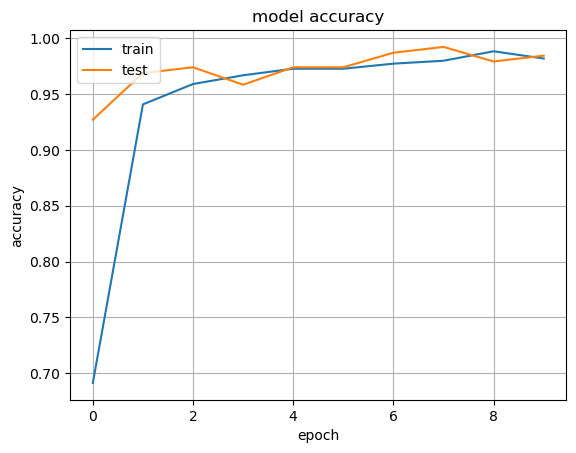

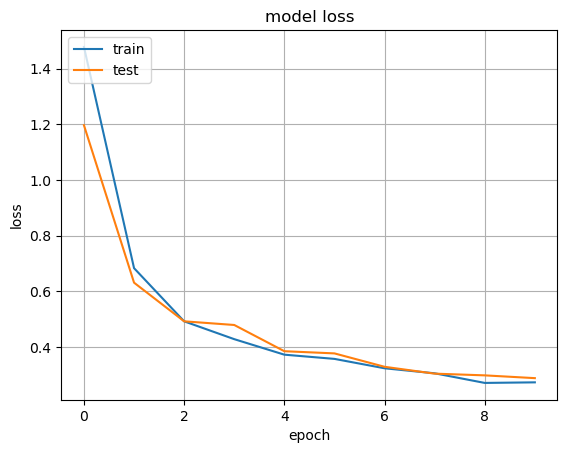

In [50]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'],loc = 'upper left')
plt.grid()
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'],loc = 'upper left')
plt.grid()
plt.show()

In [16]:
model.save('model1.h5')

In [38]:
from tensorflow.keras.models import load_model

model = load_model('model1.h5')

In [51]:
# Đường dẫn đến ảnh
img = cv2.imread('data/Dat_1.jpg')
# Tiền xử lý ảnh

img = preprocess_image(img)
img = np.expand_dims(img, axis=0)

print(img.shape)


(1, 200, 200, 1)


In [52]:
import matplotlib.pyplot as plt



# Dự đoán nhãn cho tất cả ảnh trong tập dữ liệu kiểm tra
predictions = model.predict(img)
print(predictions)

# Xử lý dự đoán
final_predictions = []
for pred in predictions:
    if max(pred) < 0.5:
        final_predictions.append('Không xác định')
    else:
        final_predictions.append(np.argmax(pred))

print(final_predictions)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
[[0.11463802 0.00144704 0.45323747 0.4306774 ]]
['Không xác định']


In [21]:
label_mapping = {
    '0': 'Dat',
    '1': 'Nam',
    '2': 'NgocAnh',
    '3': 'TuNam'
}

# Gắn nhãn ngược lại cho dự đoán
final_labels = []
for pred in final_predictions:
    if pred == "Không xác định":
        final_labels.append(pred)
    else:
        # Kiểm tra trước khi truy cập key
        if str(pred) in label_mapping:
            final_labels.append(label_mapping[str(pred)])
        else:
            final_labels.append('Không xác định')  # hoặc bất kỳ giá trị nào bạn muốn gán cho nhãn không xác định

# In nhãn cuối cùng
print(final_labels)



['NgocAnh']


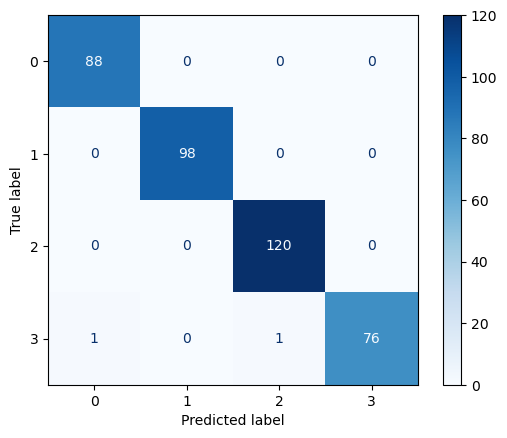

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_test_labels = np.argmax(y_test, axis=1)
pred_labels = np.argmax(predictions, axis=1)

# Tính toán ma trận confusion
cm = confusion_matrix(y_test_labels, pred_labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()
